In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
from nb_001b import *
from PIL import Image
import PIL, matplotlib.pyplot as plt
from torch.utils.data import Dataset
from operator import itemgetter, attrgetter
from numpy import random

# CIFAR subset data

## Setup

In [179]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

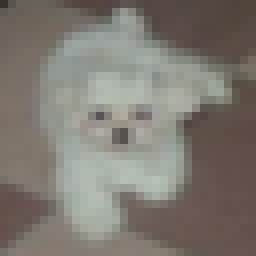

In [180]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

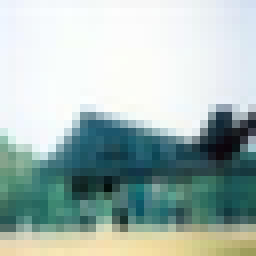

In [181]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

In [195]:
def find_classes(folder):
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

def get_image_files(c):
    return [o for o in list(c.iterdir())
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = np.array(image, dtype=np.float32)/255.
    if len(arr.shape)==2: arr = np.repeat(arr[...,None],3,2)
    return torch.from_numpy(arr).permute(2,0,1).contiguous()

In [196]:
class FilesDataset(Dataset):
    def __init__(self, folder, classes):
        self.fns, self.y = [], []
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [197]:
# NB: validation or training may not have all classes
classes = [cls.name for cls in find_classes(PATH/'train')]

train_ds = FilesDataset(PATH/'train', classes)
valid_ds = FilesDataset(PATH/'test', classes)

In [198]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [200]:
def image2np(image): return image.cpu().permute(1,2,0).numpy()

airplane


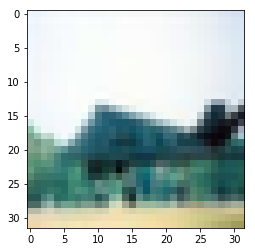

In [201]:
x,y = train_ds[0]
plt.imshow(image2np(x))
print(train_ds.classes[y])

In [202]:
import torch
default_device = torch.device('cuda', 0)

In [203]:
bs=64

In [204]:
data = DataBunch(train_ds, valid_ds, bs=bs)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [208]:
def show_image(img, ax=None, figsize=(3,3)):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    ax.axis('off')

def show_image_batch(dl, classes, rows=None):
    if rows is None: rows = int(math.sqrt(len(x)))
    x,y = next(iter(dl))[:rows*rows]
    show_images(x,y,rows, classes)

def show_images(x,y,rows, classes):
    fig, axs = plt.subplots(rows,rows,figsize=(12,15))
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

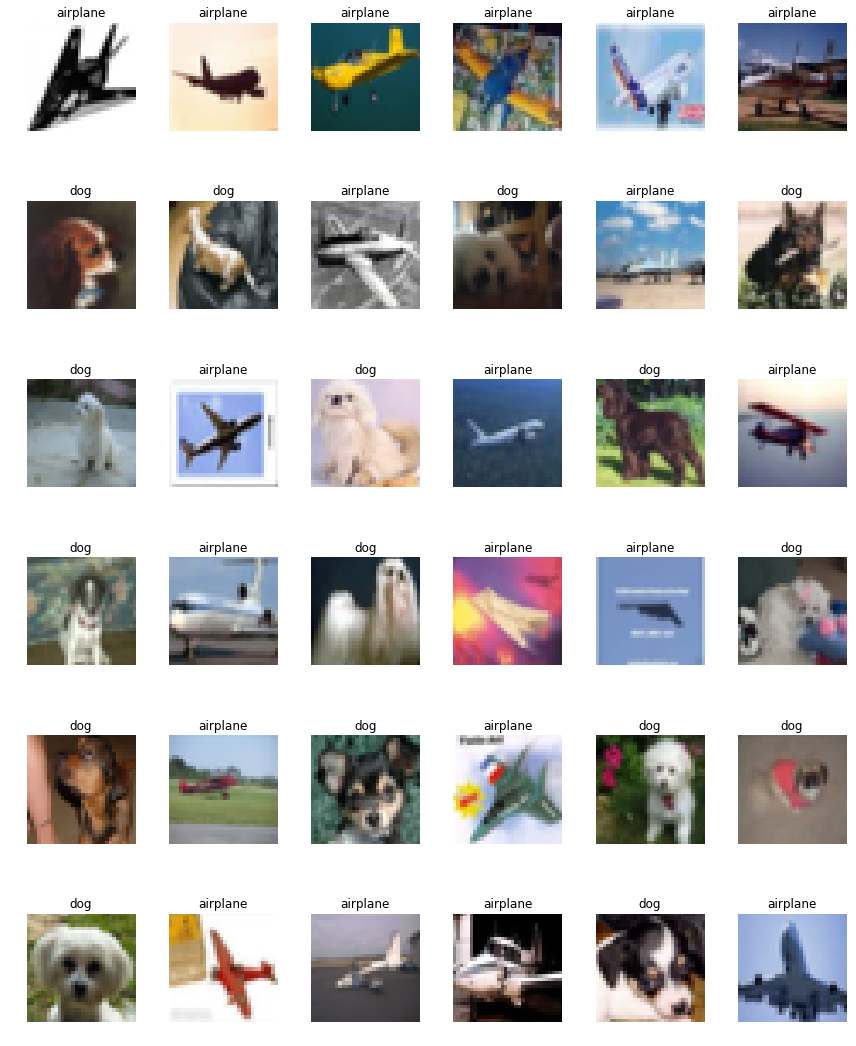

In [209]:
show_image_batch(data.train_dl, classes, 6)

## Simplify transforms

In [211]:
x,_ = next(iter(data.train_dl))

In [212]:
x.shape

torch.Size([64, 3, 32, 32])

In [252]:
def get_batch_stats(dl):
    x,_ = next(iter(dl))
    # hack for multi-axis reduction until pytorch has it natively
    x = x.transpose(0,1).contiguous().view(x.size(1),-1)
    return x.mean(1), x.std(1)

In [253]:
data_mean,data_std = get_batch_stats(data.train_dl)
data_mean,data_std

(tensor([0.5017, 0.5105, 0.5048], device='cuda:0'),
 tensor([0.2404, 0.2411, 0.2642], device='cuda:0'))

In [254]:
noop = lambda x: x

def xy_transform(x_tfm=None, y_tfm=None):
    if x_tfm is None: x_tfm = noop
    if y_tfm is None: y_tfm = noop
    return lambda b: (x_tfm(b[0]), y_tfm(b[1]))

def xy_transforms(x_tfms=None, y_tfms=None):
    x_tfms = listify(x_tfms)
    if y_tfms is None: y_tfms=noop
    y_tfms = listify(y_tfms, x_tfms)
    return list(map(xy_transform, x_tfms, y_tfms))

In [255]:
def normalize(mean,std,x): return (x-mean.reshape(3,1,1))/std.reshape(3,1,1)

In [256]:
cifar_transforms = [
    partial(normalize, data_mean, data_std)
]

cifar_xy_transforms = xy_transforms(cifar_transforms)

In [257]:
data2 = DataBunch(train_ds, valid_ds, bs=bs, train_tfms=cifar_xy_transforms, valid_tfms=cifar_xy_transforms)
len(data2.train_dl), len(data2.valid_dl)

(157, 16)

In [265]:
x,y = next(iter(data2.train_dl))

In [266]:
def denorm(x): return x * data_std.reshape(3,1,1) + data_mean.reshape(3,1,1)

In [267]:
x = denorm(x)

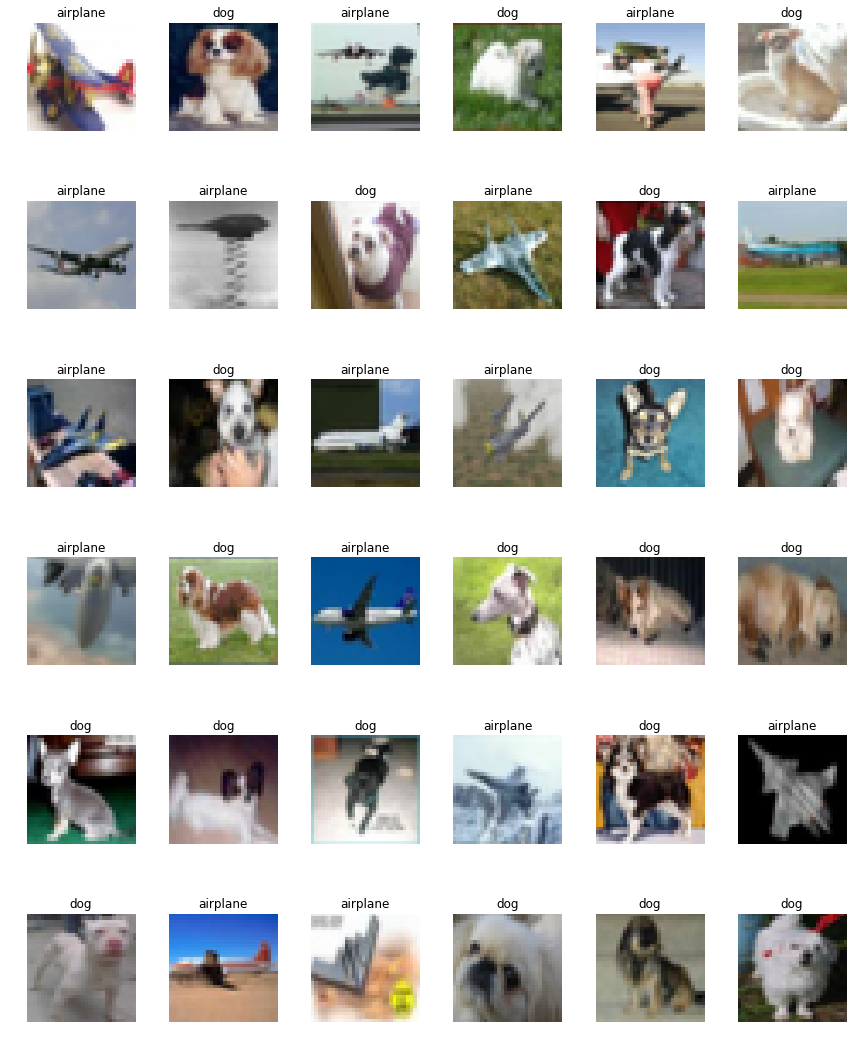

In [268]:
show_images(x,y,6,classes)

In [269]:
learn = Learner(data2, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [270]:
learn.fit(2, 0.1)

0 0.5448387775421143


1 0.44640082454681396


# Data augmentation

## Random brightness

In [633]:
def log_uniform(low, high):
    return np.exp(random.uniform(np.log(low), np.log(high)))

In [645]:
def brightness(x, scale: log_uniform): return x.mul_(scale).clamp_(0,1)

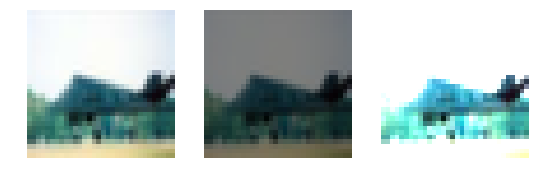

In [649]:
_,axes = plt.subplots(1,3, figsize=(9,3))

show_image(train_ds[0][0], axes[0])
show_image(brightness(train_ds[0][0], 0.5), axes[1])
show_image(brightness(train_ds[0][0], 2.0), axes[2])

In [631]:
def func_rand_kw(func, kwargs):
    return {k:func.__annotations__[k](*v) for k,v in kwargs.items()}    

def func_rand(func, **kwargs):
    return lambda x: func(x, **func_rand_kw(func, kwargs))

In [637]:
brightness_tfm = lambda low=1.0,hi=1.0: func_rand(brightness, scale=(low,hi))

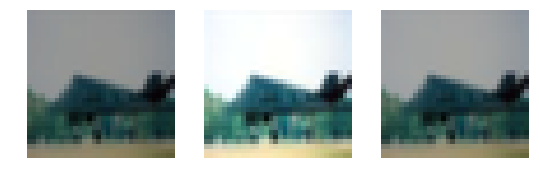

In [651]:
tfm = brightness_tfm(0.5,2)

_,axes = plt.subplots(1,3, figsize=(9,3))
for ax in axes: show_image(tfm(train_ds[0][0]), ax)

## Decorator

In [639]:
def reg_transform(tfm_type):
    def decorator(func):
        func.tfm_type = tfm_type
        return func
    return decorator

In [641]:
@reg_transform('pixel')
def brightness(x, scale: log_uniform): return x.mul_(scale).clamp_(0,1)

In [642]:
brightness.tfm_type

'pixel'

## Affine

In [344]:
def grid_sample(x, coords, padding='reflect'):
    if padding=='reflect': # Reflect padding isn't implemented in grid_sample yet
        coords[coords < -1] = coords[coords < -1].mul_(-1).add_(-2)
        coords[coords > 1] = coords[coords > 1].mul_(-1).add_(2)
        padding='zeros'
    return F.grid_sample(x[None], coords, padding_mode=padding)[0]

In [345]:
def affine_coords(x, matrix):
    return F.affine_grid(matrix[None,:2], x[None].size())

In [346]:
def rotate_matrix(degrees):
    angle = degrees * math.pi / 180
    return [[math.cos(angle), -math.sin(angle), 0.],
            [math.sin(angle),  math.cos(angle), 0.],
            [0.             ,  0.             , 1.]]

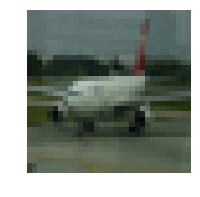

In [382]:
img = train_ds[1][0]
show_image(img)

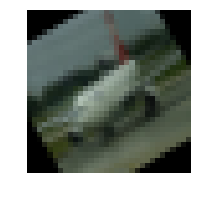

In [383]:
m = rotate_matrix(30)
m = img.new_tensor(m)
c = affine_coords(img, m)
img2 = grid_sample(img, c, padding='zeros')
show_image(img2)

In [397]:
def do_affine(img, m):
    c = affine_coords(img,  img.new_tensor(m))
    return grid_sample(img, c, padding='zeros')

def zoom_matrix(zoom):
    return [[zoom, 0,    0.],
            [0,    zoom, 0.],
            [0,    0   , 1.]]

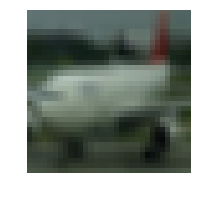

In [400]:
show_image(do_affine(img, zoom_matrix(0.6)))

In [387]:
def eye_like(x, n): return torch.eye(n, out=x.new_empty((n,n)))

def affines_mat(x, matrices):
    matrices = list(map(x.new_tensor, matrices))
    return reduce(torch.matmul, matrices, eye_like(x, 3))

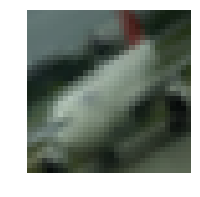

In [404]:
c = affines_mat(img, [zoom_matrix(0.6), rotate_matrix(30)])
show_image(do_affine(img, c))

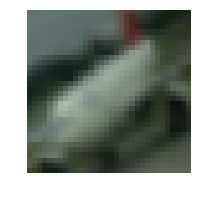

In [405]:
img2 = do_affine(img,  rotate_matrix(30))
img2 = do_affine(img2, zoom_matrix(0.6))
show_image(img2)

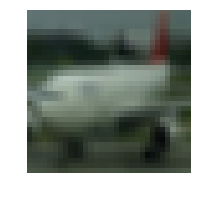

In [406]:
c = affines_mat(img, [zoom_matrix(0.6)])
show_image(do_affine(img, c))

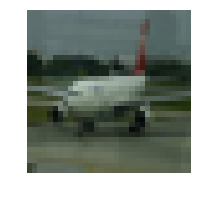

In [407]:
c = affines_mat(img, [])
show_image(do_affine(img, c))